# The Setup

In [5]:
import os

import re
import datetime as dt
import json

import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt


In [32]:
#config.py

OW_API_URL="http://api.openweathermap.org/geo/1.0/zip?zip={zip},US&appid={api_key}"
API_KEY= os.getenv("OPENWEATHER_KEY") # <YOUR_API_KEY>

ZILLOW_HOMES_URL="https://www.zillow.com/{city}-{state}/{property_type}/{page}_p"

HOME_HEADER_CLASS=("div",{"class":"StyledPropertyCardDataWrapper-c11n-8-85-1__sc-1omp4c3-0 jVBMsP property-card-data"})
HOME_PAGE_CLASS=("span",{"class":"Text-c11n-8-85-1__sc-aiai24-0 bEkett"})
HOME_PRICE_CLASS=("div",{"class":"StyledPropertyCardDataArea-c11n-8-85-1__sc-yipmu-0 bqsBln"})
HOME_SPACE_CLASS=("ul",{"class":"StyledPropertyCardHomeDetailsList-c11n-8-85-1__sc-1xvdaej-0 dmDolk"})
HOME_ADDRESS_CLASS=("a",{"class":"StyledPropertyCardDataArea-c11n-8-85-1__sc-yipmu-0 gdfTyO property-card-link"})

LIST_ITEM_CLASS="li"
LIST_ITEM_IDENTIFIER="abbr"

ERROR_404_CONSTANT='zillow-error-page'
BOT_CAUGHT_CONSTANT='robots'

In [33]:
API_KEY

In [8]:
city_states=[('Houston','TX')]

In [9]:
#main.py

l=[]
h={}

for city, state in city_states:  
    while True:
        num_var=np.random.randint(100,1000)
        num_var3=np.random.randint(10,100)
        num_var2=num_var3%10
        num_var4=np.random.randint(1000,10000)
        num_var5=np.random.randint(100,1000)

        _header={"User-Agent": f"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/{num_var5}.36 (KHTML, like Gecko) Chrome/51.{num_var2}.2704.{num_var} Safari/537.{num_var3} OPR/38.0.{num_var4}.41"}
        _page_req=requests.get(ZILLOW_HOMES_URL.format(city=city.lower(),
                                                        state=state.lower(),
                                                        property_type='homes',
                                                        page='2'),headers=_header)

        _page_text = _page_req.text

        _page_soup=BeautifulSoup(_page_text,'html.parser')

        try:
            if _page_soup.find('div')['id']==ERROR_404_CONSTANT:
                break
        except:
            pass
        
        if _page_soup.find('meta')['name']==BOT_CAUGHT_CONSTANT:
            continue
        else:
            if _page_soup.find(HOME_PAGE_CLASS[0],HOME_PAGE_CLASS[1]) == None:
                _page_max=1
            else:
                _target_text=_page_soup.find(HOME_PAGE_CLASS[0],HOME_PAGE_CLASS[1]).text

                _page_max=int(re.findall('(\d+)',_target_text)[1])
            break


    for p_idx in range(2,(_page_max+2)):
        try:
            if _page_soup.find('div')['id']==ERROR_404_CONSTANT:
                break
        except:
                pass
            
        while True:
            num_var=np.random.randint(100,1000)
            num_var3=np.random.randint(10,100)
            num_var2=num_var3%10
            num_var4=np.random.randint(1000,10000)
            num_var5=np.random.randint(100,1000)

            header={"User-Agent": f"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/{num_var5}.36 (KHTML, like Gecko) Chrome/51.{num_var2}.2704.{num_var} Safari/537.{num_var3} OPR/38.0.{num_var4}.41"}
            req = requests.get(ZILLOW_HOMES_URL.format(city=city.lower(),
                                                        state=state.lower(),
                                                        property_type='homes',
                                                        page=p_idx),headers=header)
            
            r_text=req.text


            soup = BeautifulSoup(r_text,'html.parser')


            if soup.find('meta')['name']==BOT_CAUGHT_CONSTANT:
                continue

            else:

                homes = soup.find_all(HOME_HEADER_CLASS[0],HOME_HEADER_CLASS[1])

                for home in homes:

                    p_list=home.find(HOME_PRICE_CLASS[0],HOME_PRICE_CLASS[1]).text
                    try:
                        h['price']=int("".join(re.findall('(\d+)',p_list)))
                    except:
                        h['price']=None


                    s_list=home.find(HOME_SPACE_CLASS[0],HOME_SPACE_CLASS[1])
                    try:
                        s_list_list = s_list.find_all('li')
                        for li_idx in range(len(s_list_list)):
                            li_identifier = s_list_list[li_idx].find('abbr')  
                            try:
                                if re.findall("(bd)", li_identifier.text)[0] == 'bd': 
                                    h['bd'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                            except:
                                pass
                        
                            try:
                                if re.findall("(ba)", li_identifier.text)[0] == 'ba':  
                                    h['ba'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                            except:
                                pass
                            
                            try:
                                if re.findall("(sqft)", li_identifier.text)[0] == 'sqft':
                                    h['sqft'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                            except:
                                pass
                    except:
                        pass


                    a_list=home.find(HOME_ADDRESS_CLASS[0],HOME_ADDRESS_CLASS[1]).text.split(",")
                    try:
                        h['address']=a_list[0].strip()
                    except:
                        h['address']=None
                    try:
                        h['city']=a_list[1].strip()
                    except:
                        h['city']=None
                    try:
                        h['state']=a_list[2].strip().split()[0]
                    except:
                        h['state']=None
                    try:
                        h['zip']=a_list[2].strip().split()[1]
                    except:
                        h['zip']=None


                    header={"content-type": "application/json"}
                    req=requests.get(OW_API_URL.format(zip=h['zip'],api_key=API_KEY),headers=header)

                    json_loads=json.loads(req.text)

                    try:
                        h['lat']=float(json_loads['lat'])
                        h['lon']=float(json_loads['lon'])
                    except:
                        h['lat']=None
                        h['lon']=None




                    l.append(h)
                    h={}
            break


In [10]:
df=pd.DataFrame(l)

# Onwards and Upwards

In [11]:
import time

dict={'zillow_call':[],'structure_data':[],'openweather_call':[]}

In [12]:
for i in range(0,100):

    tic=time.perf_counter()
    num_var=np.random.randint(100,1000)
    num_var3=np.random.randint(10,100)
    num_var2=num_var3%10
    num_var4=np.random.randint(1000,10000)
    num_var5=np.random.randint(100,1000)

    _header={"User-Agent": f"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/{num_var5}.36 (KHTML, like Gecko) Chrome/51.{num_var2}.2704.{num_var} Safari/537.{num_var3} OPR/38.0.{num_var4}.41"}
    _page_req=requests.get(ZILLOW_HOMES_URL.format(city=city.lower(),
                                                    state=state.lower(),
                                                    property_type='homes',
                                                    page='2'),headers=_header)

    _page_text = _page_req.text

    page_soup=BeautifulSoup(_page_text,'html.parser')

    toc=time.perf_counter()

    dict['zillow_call'].append(toc-tic)

In [13]:
for i in range(0,100):

    tic=time.perf_counter()

    homes = soup.find_all(HOME_HEADER_CLASS[0],HOME_HEADER_CLASS[1])

    for home in homes:

        p_list=home.find(HOME_PRICE_CLASS[0],HOME_PRICE_CLASS[1]).text
        try:
            h['price']=int("".join(re.findall('(\d+)',p_list)))
        except:
            h['price']=None


        s_list=home.find(HOME_SPACE_CLASS[0],HOME_SPACE_CLASS[1])
        try:
            s_list_list = s_list.find_all('li')
            for li_idx in range(len(s_list_list)):
                li_identifier = s_list_list[li_idx].find('abbr')  
                try:
                    if re.findall("(bd)", li_identifier.text)[0] == 'bd': 
                        h['bd'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                except:
                    pass
            
                try:
                    if re.findall("(ba)", li_identifier.text)[0] == 'ba':  
                        h['ba'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                except:
                    pass
                
                try:
                    if re.findall("(sqft)", li_identifier.text)[0] == 'sqft':
                        h['sqft'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                except:
                    pass
        except:
            pass


        a_list=home.find(HOME_ADDRESS_CLASS[0],HOME_ADDRESS_CLASS[1]).text.split(",")
        try:
            h['address']=a_list[0].strip()
        except:
            h['address']=None
        try:
            h['city']=a_list[1].strip()
        except:
            h['city']=None
        try:
            h['state']=a_list[2].strip().split()[0]
        except:
            h['state']=None
        try:
            h['zip']=a_list[2].strip().split()[1]
        except:
            h['zip']=None

    toc=time.perf_counter()

    dict['structure_data'].append(toc-tic)

In [14]:
for i in range(0,100):    
    tic=time.perf_counter()

    header={"content-type": "application/json"}
    req=requests.get(OW_API_URL.format(zip=h['zip'],api_key=API_KEY),headers=header)

    json_loads=json.loads(req.text)

    try:
        h['lat']=float(json_loads['lat'])
        h['lon']=float(json_loads['lon'])
    except:
        h['lat']=None
        h['lon']=None

    toc=time.perf_counter()

    dict['openweather_call'].append(toc-tic)

0.7635969180000011
0.0033203840000001605
0.10953269400000039


<AxesSubplot:>

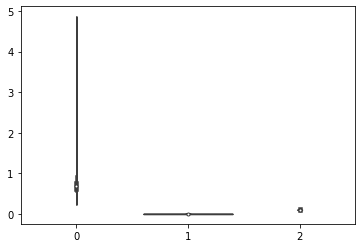

In [16]:
def mean(list):
    mean=sum(list)/len(list)
    return mean

print(mean(dict['zillow_call']))
print(mean(dict['structure_data']))
print(mean(dict['openweather_call']))


In [47]:
df=pd.DataFrame({"Zillow Webpage Call":dict['zillow_call'],"Structuring the Data":dict['structure_data'],"Openweather API Call":dict['openweather_call']})


df=df.apply(lambda x: x*1000)

df

,Zillow Webpage Call,Structuring the Data,Openweather API Call
0,745.7972,4.6860,120.5403
1,842.0817,3.5495,106.8728
2,652.7575,3.4101,102.2536
3,706.0276,3.1337,102.4875
4,698.2002,3.2514,105.0181
...,...,...,...
95,596.1299,3.1235,118.0538
96,655.2533,3.9942,106.4741
97,614.1820,3.3673,107.7404
98,727.7686,3.1088,107.0657


c:\Users\rsher\anaconda3\envs\Python4DS-Clone\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 40.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rsher\anaconda3\envs\Python4DS-Clone\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 83.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

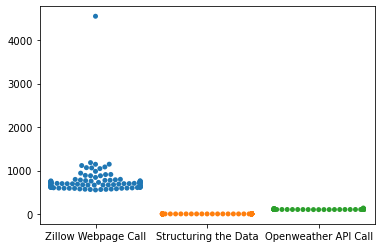

In [48]:
sns.swarmplot(data=df)

<AxesSubplot:>

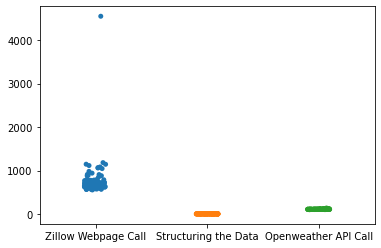

In [49]:
sns.stripplot(data=df)

In [52]:
df2=df

df2['Openweather API Call']=df2['Openweather API Call'].apply(lambda x: x*9)

In [63]:
df2=df2.drop(25,axis=0)

c:\Users\rsher\anaconda3\envs\Python4DS-Clone\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 82.8% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
c:\Users\rsher\anaconda3\envs\Python4DS-Clone\lib\site-packages\seaborn\categorical.py:1296: UserWarning: 30.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:>

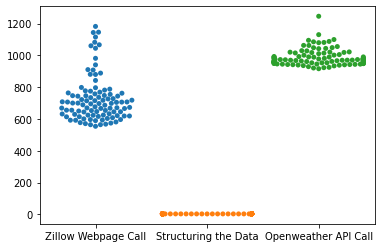

In [68]:
sns.swarmplot(data=df2)

<AxesSubplot:>

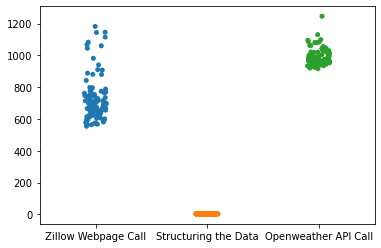

In [69]:
sns.stripplot(data=df2)

# Memoization

In [ ]:
import functools
import logging
import time

def mean(list):
    mean=sum(list)/len(list)
    return mean

In [ ]:
memory = {}

def memoize_zip_codes(func):
    def wrapper(dict):
        if dict['zip'] not in memory:
            json_loads=func(dict) # CALL OW_api_call
            try:
                memory[dict['zip']]={'lat':json_loads['lat'],"lon":json_loads['lon']} # ADD NOVEL ZIP CODE TO memory
            except:
                pass
        else:
            dict['lat']=memory[dict['zip']]['lat'] # GET ZIP CODE COORDINATES FROM memory
            dict['lon']=memory[dict['zip']]['lon']
        return func
    return wrapper

In [ ]:
@memoize_zip_codes
def OW_api_call(dict):
    header={"content-type": "application/json"}
    req=requests.get(OW_API_URL.format(zip=dict['zip'],api_key=API_KEY),headers=header)

    json_loads=json.loads(req.text)

    try:
        dict['lat']=float(json_loads['lat'])
        dict['lon']=float(json_loads['lon'])
        

    except:
        dict['lat']=None
        dict['lon']=None

    return json_loads

In [ ]:
l=[]
h={}

for city, state in city_states:  
    while True:
        num_var=np.random.randint(100,1000)
        num_var3=np.random.randint(10,100)
        num_var2=num_var3%10
        num_var4=np.random.randint(1000,10000)
        num_var5=np.random.randint(100,1000)

        _header={"User-Agent": f"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/{num_var5}.36 (KHTML, like Gecko) Chrome/51.{num_var2}.2704.{num_var} Safari/537.{num_var3} OPR/38.0.{num_var4}.41"}
        _page_req=requests.get(ZILLOW_HOMES_URL.format(city=city.lower(),
                                                        state=state.lower(),
                                                        property_type='homes',
                                                        page='2'),headers=_header)

        _page_text = _page_req.text

        _page_soup=BeautifulSoup(_page_text,'html.parser')

        try:
            if _page_soup.find('div')['id']==ERROR_404_CONSTANT:
                break
        except:
            pass
        
        if _page_soup.find('meta')['name']==BOT_CAUGHT_CONSTANT:
            continue
        else:
            if _page_soup.find(HOME_PAGE_CLASS[0],HOME_PAGE_CLASS[1]) == None:
                _page_max=1
            else:
                _target_text=_page_soup.find(HOME_PAGE_CLASS[0],HOME_PAGE_CLASS[1]).text

                _page_max=int(re.findall('(\d+)',_target_text)[1])
            break


    for p_idx in range(2,(_page_max+2)):
        try:
            if _page_soup.find('div')['id']==ERROR_404_CONSTANT:
                break
        except:
                pass
            
        while True:
            num_var=np.random.randint(100,1000)
            num_var3=np.random.randint(10,100)
            num_var2=num_var3%10
            num_var4=np.random.randint(1000,10000)
            num_var5=np.random.randint(100,1000)

            header={"User-Agent": f"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/{num_var5}.36 (KHTML, like Gecko) Chrome/51.{num_var2}.2704.{num_var} Safari/537.{num_var3} OPR/38.0.{num_var4}.41"}
            req = requests.get(ZILLOW_HOMES_URL.format(city=city.lower(),
                                                        state=state.lower(),
                                                        property_type='homes',
                                                        page=p_idx),headers=header)
            
            r_text=req.text


            soup = BeautifulSoup(r_text,'html.parser')


            if soup.find('meta')['name']==BOT_CAUGHT_CONSTANT:
                continue

            else:

                homes = soup.find_all(HOME_HEADER_CLASS[0],HOME_HEADER_CLASS[1])

                for home in homes:

                    p_list=home.find(HOME_PRICE_CLASS[0],HOME_PRICE_CLASS[1]).text
                    try:
                        h['price']=int("".join(re.findall('(\d+)',p_list)))
                    except:
                        h['price']=None


                    s_list=home.find(HOME_SPACE_CLASS[0],HOME_SPACE_CLASS[1])
                    try:
                        s_list_list = s_list.find_all('li')
                        for li_idx in range(len(s_list_list)):
                            li_identifier = s_list_list[li_idx].find('abbr')  
                            try:
                                if re.findall("(bd)", li_identifier.text)[0] == 'bd': 
                                    h['bd'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                            except:
                                pass
                        
                            try:
                                if re.findall("(ba)", li_identifier.text)[0] == 'ba':  
                                    h['ba'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                            except:
                                pass
                            
                            try:
                                if re.findall("(sqft)", li_identifier.text)[0] == 'sqft':
                                    h['sqft'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                            except:
                                pass
                    except:
                        pass


                    a_list=home.find(HOME_ADDRESS_CLASS[0],HOME_ADDRESS_CLASS[1]).text.split(",")
                    try:
                        h['address']=a_list[0].strip()
                    except:
                        h['address']=None
                    try:
                        h['city']=a_list[1].strip()
                    except:
                        h['city']=None
                    try:
                        h['state']=a_list[2].strip().split()[0]
                    except:
                        h['state']=None
                    try:
                        h['zip']=a_list[2].strip().split()[1]
                    except:
                        h['zip']=None
  

                    OW_api_call(h)

                    l.append(h)
                    h={}
            break

In [ ]:
list=[]
for i in range(0,100):
    tic=time.perf_counter()
    OW_api_call(l[0])
    toc=time.perf_counter()

    list.append(toc-tic)

print(mean(list))

# Multi-Threading

In [ ]:
import concurrent.futures
import time

In [ ]:
def modify(x):
    x**=2
    return x

In [ ]:
# NON-IDLE PROGRAM WITHOUT MULTI-THREADING
tic=time.perf_counter()

tlist=[]

for i in range(0,100):
    i=modify(i)
    tlist.append(i)

toc=time.perf_counter()

print(toc-tic)

In [ ]:
# NON-IDLE PROGRAM WITH MULTI-THREADING
tic=time.perf_counter()

t2list=[]
with concurrent.futures.ThreadPoolExecutor() as executor:
    future=[executor.submit(modify,i) for i in range(0,100)]
    for future in concurrent.futures.as_completed(future):
        t2list.append(future.result())
        

toc=time.perf_counter()

print(toc-tic)

In [ ]:
def generate_urls(city_states,property_type:str,page_max_dict:dict=None):
        urls=[]
        for city,state in city_states:
            try:
                page_max=page_max_dict[(city,state)]
            except:
                page_max=1
            for page in range(2,page_max+2):
                urls.append(((city,state),ZILLOW_HOMES_URL.format(city=city.lower(),
                                                    state=state.lower(),
                                                    property_type=property_type,
                                                    page=page)))
        return urls

In [ ]:
def get_soup(url):

        while True:
            num_var=np.random.randint(100,1000)
            num_var3=np.random.randint(10,100)
            num_var2=num_var3%10
            num_var4=np.random.randint(1000,10000)
            num_var5=np.random.randint(100,1000)

            header={"User-Agent": f"Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/{num_var5}.36 (KHTML, like Gecko) Chrome/51.{num_var2}.2704.{num_var} Safari/537.{num_var3} OPR/38.0.{num_var4}.41"}
                
            
            req=requests.get(url,
                        headers=header)

            req_text=req.text

            soup=BeautifulSoup(req_text,'html.parser')

            # ERROR CHECKING GOES HERE ...
            
            break

        return soup

In [ ]:
def threaded_request(func,urls):
        soups=[]

        with concurrent.futures.ThreadPoolExecutor() as executor:
            future_to_url = {executor.submit(func,url):
                             city_state_tup for (city_state_tup,url) in urls
                             }
            for future in concurrent.futures.as_completed(future_to_url):
                city_state_tup = future_to_url[future]
                try:
                    soups.append((city_state_tup,future.result()))
                except:
                    pass
        return soups

In [ ]:
tic=time.perf_counter()
city_states=[('Houston','TX')]

l=[]
h={}
page_max_dict={}


page_max_urls = generate_urls(city_states,property_type='homes')

page_max_soups = threaded_request(func=get_soup,urls=page_max_urls)

for city_state_tup,soup in page_max_soups:
    if soup.find(HOME_PAGE_CLASS[0],HOME_PAGE_CLASS[1])==None:
        page_max_dict[city_state_tup]=1

    else:
        target_text=soup.find(HOME_PAGE_CLASS[0],HOME_PAGE_CLASS[1]).text

        page_max_dict[city_state_tup]=int(re.findall('(\d+)',_target_text)[1])




main_urls=generate_urls(city_states=city_states,property_type='homes',page_max_dict=page_max_dict)
      

main_soups=threaded_request(func=get_soup,urls=main_urls)

for city_state_tup,soup in main_soups:
    homes = soup.find_all(HOME_HEADER_CLASS[0],HOME_HEADER_CLASS[1])

    for home in homes:

        p_list=home.find(HOME_PRICE_CLASS[0],HOME_PRICE_CLASS[1]).text
        try:
            h['price']=int("".join(re.findall('(\d+)',p_list)))
        except:
            h['price']=None


        s_list=home.find(HOME_SPACE_CLASS[0],HOME_SPACE_CLASS[1])
        try:
            s_list_list = s_list.find_all('li')
            for li_idx in range(len(s_list_list)):
                li_identifier = s_list_list[li_idx].find('abbr')  
                try:
                    if re.findall("(bd)", li_identifier.text)[0] == 'bd': 
                        h['bd'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                except:
                    pass
            
                try:
                    if re.findall("(ba)", li_identifier.text)[0] == 'ba':  
                        h['ba'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                except:
                    pass
                
                try:
                    if re.findall("(sqft)", li_identifier.text)[0] == 'sqft':
                        h['sqft'] = int("".join(re.findall('(\d+)', s_list_list[li_idx].text)))
                except:
                    pass
        except:
            pass


        a_list=home.find(HOME_ADDRESS_CLASS[0],HOME_ADDRESS_CLASS[1]).text.split(",")
        try:
            h['address']=a_list[0].strip()
        except:
            h['address']=None
        try:
            h['city']=a_list[1].strip()
        except:
            h['city']=None
        try:
            h['state']=a_list[2].strip().split()[0]
        except:
            h['state']=None
        try:
            h['zip']=a_list[2].strip().split()[1]
        except:
            h['zip']=None


        OW_api_call(h)

        l.append(h)
        h={}
toc=time.perf_counter()

print(toc-tic)